In [29]:
import mne
import numpy as np
from scipy import io as sio, signal, stats
import matplotlib.pyplot as plt
from statsmodels.regression.linear_model import yule_walker as yw

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

from mne import io, pick_types, read_events, Epochs, EvokedArray
from mne.datasets import sample
from mne.preprocessing import Xdawn
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)

import pyriemann

mne.set_log_level('ERROR')

### Helper func.

In [3]:
def load_data(path='./ecog/ECoG_Handpose.mat'):
    data = sio.loadmat(path)
    sfreq = 1200.0

    time = data['y'][0]
    ecog = data['y'][1:61]
    stim = data['y'][61:]

    chan_idx = np.arange(1, ecog.shape[0] + 1)

    ch_names = ['ECoG{}'.format(i) for i in chan_idx] # list of channels names
    ch_names += ['gesture', 'thumb', 'index', 'middle', 'ring', 'little']
    ch_types = ['ecog']*len(ecog) # list of channels types (all EEG)
    ch_types += ['stim']
    ch_types += ['misc']*5

    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types) # create mne info object
    raw = mne.io.RawArray(data['y'][1:], info) # create mne RawArray
    
    return raw

def preprocess(raw, bp=[1,300], notch=True, avg_ref=True, whiten=False):
    raw.filter(*bp)
    if notch:
        raw.notch_filter(np.arange(50,raw.info['sfreq']/2,50), notch_widths=2, trans_bandwidth=10)
    if whiten:
        raw = whiten_raw(raw)    
    if avg_ref:
        raw.set_eeg_reference('average')
    return raw

def whiten_raw(raw):
    data = raw.get_data()
    data_wh = np.zeros(data[:60].shape)
    for i in range(len(data_wh)):
        arcoeff, v = yw(data[i], 10)
        data_wh[i] = signal.lfilter(-arcoeff[1:], 1, data[i])

    data[:60] = data_wh 
    raw_wh = mne.io.RawArray(data, raw.info)
    
    return raw_wh

### Basic I/O

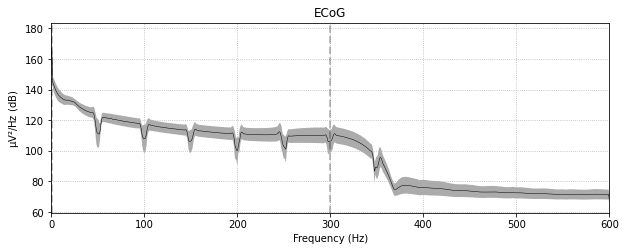

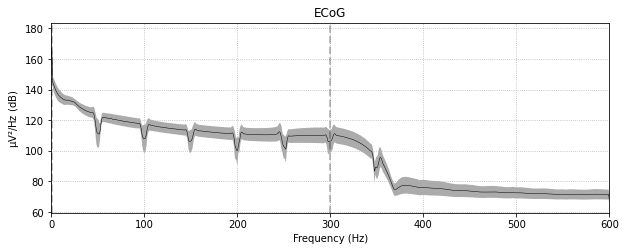

In [4]:
raw = load_data()
raw = preprocess(raw)

raw.plot_psd(average=True)

### Event-related potentials

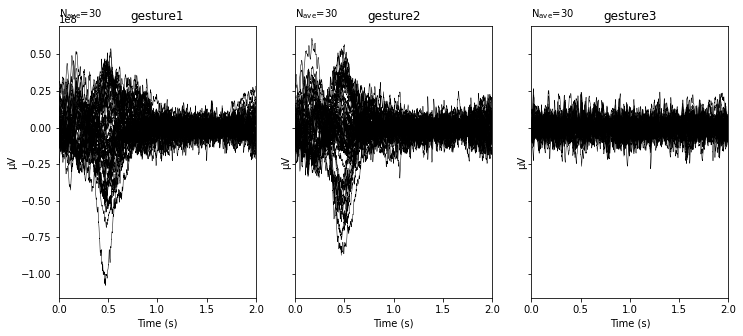

In [5]:
raw = load_data()
raw = preprocess(raw)

events = mne.find_events(raw, stim_channel='gesture')
event_id = {'gesture1': 1, 'gesture2': 2, 'gesture3': 3}

tmin=0.
tmax=2.

picks = mne.pick_types(raw.info, ecog=True)

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
                picks=picks, baseline=None, preload=True,
                verbose=False)

f, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,5))

for a, k in zip(ax, event_id.keys()):
    epochs[k].average().plot(axes=a,show=False)
    a.set_title(k)

### MNE stock decoders

#### CSP

Approx. 87% accuracy!

Edit - low + high frequencies - 96.7% accuracy!

In [6]:
raw = load_data()
raw = preprocess(raw, bp=[1,250])
raw.resample(600)

events = mne.find_events(raw, stim_channel='gesture')
event_id = {'gesture1': 1, 'gesture2': 2, 'gesture3': 3}

tmin=0.
tmax=2.

picks = mne.pick_types(raw.info, ecog=True)

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
                    picks=picks, baseline=None, preload=True,
                    verbose=False)

In [7]:
# Get the labels
X = epochs.get_data()  # MEG signals: n_epochs, n_meg_channels, n_times
y = epochs.events[:, 2]  # target: auditory left vs visual left

# for n_filter in range(1,30):
n_filter = 6

print('N_comp: {}'.format(n_filter))

csp = CSP(n_components=n_filter, norm_trace=False)
clf_csp = make_pipeline(csp, StandardScaler(), LinearModel(LogisticRegression(solver='lbfgs', C=.1, max_iter=10000)))
scores = cross_val_multiscore(clf_csp, X, y, cv=10, n_jobs=-1)

print('Accuracy: {:.3f} +/- {:.3f}'.format(scores.mean(), scores.std()))

N_comp: 6
Accuracy: 0.967 +/- 0.051


In [8]:
%%timeit
clf_csp.fit(X,y)

3.75 s ± 22.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%%timeit
clf_csp.predict(X[0,np.newaxis])

368 µs ± 31 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### CSP + whiten

- 86% (whitened) vs 87% (non-whitened)
- 94% (n_comp = 20)

In [62]:
raw = load_data()
raw = preprocess(raw, bp=[1,250])
raw.resample(600)

raw = whiten_raw(raw)
raw.filter(50,250)

events = mne.find_events(raw, stim_channel='gesture')
event_id = {'gesture1': 1, 'gesture2': 2, 'gesture3': 3}

tmin=0.
tmax=2.

picks = mne.pick_types(raw.info, ecog=True)

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
                    picks=picks, baseline=None, preload=True,
                    verbose=False)

In [78]:
# Get the labels
X = epochs.get_data()  # MEG signals: n_epochs, n_meg_channels, n_times
y = epochs.events[:, 2]  # target: auditory left vs visual left

for n_filter in range(1,30):

    print('N_comp: {}'.format(n_filter))

    csp = CSP(n_components=n_filter, norm_trace=False)
    clf_csp = make_pipeline(csp, StandardScaler(), LinearModel(LogisticRegression(solver='lbfgs', C=.1, max_iter=10000)))
    scores = cross_val_multiscore(clf_csp, X, y, cv=10, n_jobs=-1)

    print('Accuracy: {:.3f} +/- {:.3f}'.format(scores.mean(), scores.std()))

N_comp: 1
Accuracy: 0.700 +/- 0.141
N_comp: 2
Accuracy: 0.789 +/- 0.175
N_comp: 3
Accuracy: 0.811 +/- 0.132
N_comp: 4
Accuracy: 0.822 +/- 0.124
N_comp: 5
Accuracy: 0.789 +/- 0.168
N_comp: 6
Accuracy: 0.789 +/- 0.168
N_comp: 7
Accuracy: 0.811 +/- 0.132
N_comp: 8
Accuracy: 0.789 +/- 0.153
N_comp: 9
Accuracy: 0.811 +/- 0.165
N_comp: 10
Accuracy: 0.822 +/- 0.102
N_comp: 11
Accuracy: 0.844 +/- 0.124
N_comp: 12
Accuracy: 0.856 +/- 0.100
N_comp: 13
Accuracy: 0.833 +/- 0.090
N_comp: 14
Accuracy: 0.878 +/- 0.078
N_comp: 15
Accuracy: 0.911 +/- 0.083
N_comp: 16
Accuracy: 0.933 +/- 0.074
N_comp: 17
Accuracy: 0.922 +/- 0.071
N_comp: 18
Accuracy: 0.922 +/- 0.071
N_comp: 19
Accuracy: 0.933 +/- 0.074
N_comp: 20
Accuracy: 0.933 +/- 0.074
N_comp: 21
Accuracy: 0.944 +/- 0.075
N_comp: 22
Accuracy: 0.944 +/- 0.075
N_comp: 23
Accuracy: 0.933 +/- 0.074
N_comp: 24
Accuracy: 0.922 +/- 0.071
N_comp: 25
Accuracy: 0.922 +/- 0.071
N_comp: 26
Accuracy: 0.922 +/- 0.071
N_comp: 27
Accuracy: 0.922 +/- 0.071
N_comp: 28

#### Vectorizer + logistic

Approx. 40% accuracy

In [17]:
clf = make_pipeline(Scaler(epochs.info),
                    Vectorizer(),
                    LogisticRegression(solver='lbfgs'))

scores = cross_val_multiscore(clf, X, y, cv=5, n_jobs=1)

print('Accuracy: {:.3f} +/- {:.3f}'.format(scores.mean(), scores.std()))

Accuracy: 0.389 +/- 0.061


#### XDAWN

No convergence...

In [31]:
clf = make_pipeline(Xdawn(n_components=3), 
                    Vectorizer(), 
                    MinMaxScaler(), 
                    LogisticRegression(penalty='l1', solver='liblinear', multi_class='auto'))

# Cross validator
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Do cross-validation
preds = np.empty(len(y))
for train, test in cv.split(epochs, y):
    clf.fit(epochs[train], y[train])
    preds[test] = clf.predict(epochs[test])

ValueError: Could not compute eigenvalues, ensure proper regularization (The leading minor of order 60 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.)

### Riemannian approach

In [72]:
raw = load_data()
raw = preprocess(raw, bp=[1,10])
raw.resample(30)

events = mne.find_events(raw, stim_channel='gesture')
event_id = {'gesture1': 1, 'gesture2': 2, 'gesture3': 3}

tmin=0.
tmax=2.

picks = mne.pick_types(raw.info, ecog=True)

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
                    picks=picks, baseline=None, preload=True,
                    verbose=False)

# Get the labels
X = epochs.get_data()  # MEG signals: n_epochs, n_meg_channels, n_times
y = epochs.events[:, 2]  # target: auditory left vs visual left

In [73]:
from sklearn.svm import SVC

In [74]:
from sklearn.preprocessing import normalize

In [75]:
# X_ravel = normalize(X.reshape(90,-1))
# X_norm = X.reshape(90,60,-1)


# # estimate covariances matrices
# cov = pyriemann.estimation.XdawnCovariances().fit_transform(X, y)

# # cross validation
# mdm = pyriemann.classification.MDM()


n_components = 20

clf = make_pipeline(pyriemann.estimation.XdawnCovariances(n_components),
                    pyriemann.tangentspace.TangentSpace(metric='riemann'),
                    LogisticRegression())

accuracy = cross_val_score(clf, X, y)

# clf = make_pipeline(XdawnCovariances(n_components),
#                     TangentSpace(metric='riemann'),
#                     LogisticRegression())


print(accuracy.mean())

nan


/home/mak616/anaconda2/envs/ECoG_hack/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/mak616/anaconda2/envs/ECoG_hack/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/mak616/anaconda2/envs/ECoG_hack/lib/python3.6/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/mak616/anaconda2/envs/ECoG_hack/lib/python3.6/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/mak616/anaconda2/envs/ECoG_hack/lib/python3.6/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/mak616/anaconda2/envs/ECoG_hack/lib/python3.6/site-packages/skl

In [62]:
pyriemann.classification.MDM?

Init signature: pyriemann.classification.MDM(metric='riemann', n_jobs=1)
Docstring:     
Classification by Minimum Distance to Mean.

Classification by nearest centroid. For each of the given classes, a
centroid is estimated according to the chosen metric. Then, for each new
point, the class is affected according to the nearest centroid.

Parameters
----------
metric : string | dict (default: 'riemann')
    The type of metric used for centroid and distance estimation.
    see `mean_covariance` for the list of supported metric.
    the metric could be a dict with two keys, `mean` and `distance` in
    order to pass different metric for the centroid estimation and the
    distance estimation. Typical usecase is to pass 'logeuclid' metric for
    the mean in order to boost the computional speed and 'riemann' for the
    distance in order to keep the good sensitivity for the classification.
n_jobs : int, (default: 1)
    The number of jobs to use for the computation. This works by computin

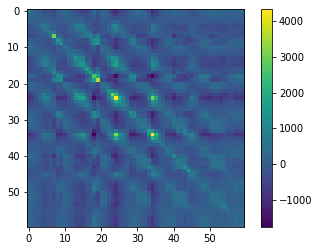

In [54]:
plt.imshow(cov[0])
plt.colorbar()

In [34]:
clf

Pipeline(steps=[('type', <class 'sklearn.preprocessing._data.StandardScaler'>),
                ('covariances', Covariances()), ('svc', SVC(kernel='linear'))])

In [26]:
stats.zscore

(90, 60, 1201)

In [25]:
np.all(cov > 0)

False

In [4]:
import sklearn

In [6]:
sklearn.show_versions()


System:
    python: 3.8.6 | packaged by conda-forge | (default, Dec 26 2020, 05:05:16)  [GCC 9.3.0]
executable: /home/mak616/anaconda2/envs/spyeeg/bin/python
   machine: Linux-4.15.0-140-generic-x86_64-with-glibc2.10

Python dependencies:
          pip: 20.3.3
   setuptools: 49.6.0.post20210108
      sklearn: 0.24.0
        numpy: 1.19.5
        scipy: 1.6.0
       Cython: None
       pandas: 1.2.0
   matplotlib: 3.3.3
       joblib: 1.0.0
threadpoolctl: 2.1.0

Built with OpenMP: True


### Sprectal whitening

Pseudocode (MATLAB):

```
[arcoeff,v]=aryule(data(ch,:),10); % AR normalised values and its variance, model order p=10 
estimated=filter(-arcoeff(2:end),1,data(ch,:));
```

Python has equivalent functionality through statsmodels?

In [56]:
raw = load_data()
raw = preprocess(raw, [1, 500], avg_ref=False)
raw_wh = whiten_raw(raw)

raw.filter(50,300)
raw_wh.filter(50,300)

<RawArray | 66 x 507025 (422.5 s), ~255.4 MB, data loaded>

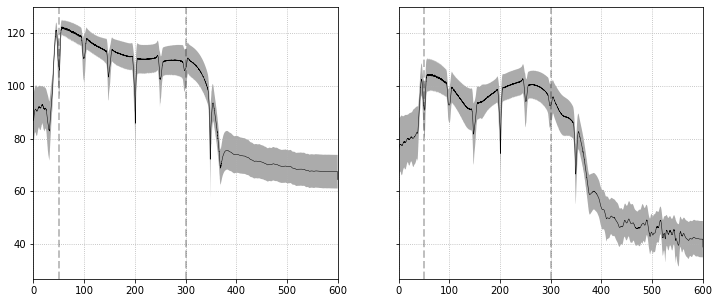

In [60]:
f, ax = plt.subplots(1,2, sharex=True, sharey=True,  figsize=(12,5))

picks=mne.pick_types(raw.info, ecog=True)

raw.plot_psd(ax=ax[0], show=False, average=True, picks=picks, n_fft=int(10*raw.info['sfreq']))
raw_wh.plot_psd(ax=ax[1], show=False, average=True, picks=picks, n_fft=int(10*raw.info['sfreq']))

plt.show()

### Custom epoching - work in progress

Creating RawArray with float64 data, n_channels=66, n_times=507025
    Range : 0 ... 507024 =      0.000 ...   422.520 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 300.00 Hz
- Upper transition bandwidth: 75.00 Hz (-6 dB cutoff frequency: 337.50 Hz)
- Filter length: 3961 samples (3.301 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 5.00 Hz
- Upp

Text(0.5, 1.0, 'Finger data')

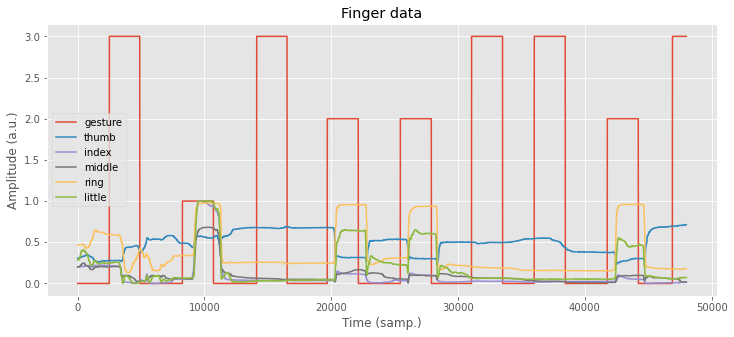

In [269]:
raw = load_data()
raw = preprocess(raw)

plt.style.use('ggplot')
plt.figure(figsize=(12,5))
plt.plot(raw.get_data()[-6:, int(10*sfreq):int(50*sfreq)].T)
plt.legend(ch_names[-6:])
plt.xlabel('Time (samp.)')
plt.ylabel('Amplitude (a.u.)')
plt.title('Finger data')

In [78]:
trigs = np.diff(raw['gesture'][0].squeeze())

In [86]:
trigs_rest = np.where(trigs < 0)[0]
trigs_gest1 = np.where(trigs == 1)[0]
trigs_gest2 = np.where(trigs == 2)[0]
trigs_gest3 = np.where(trigs == 3)[0]

(24000.0, 48000.0)

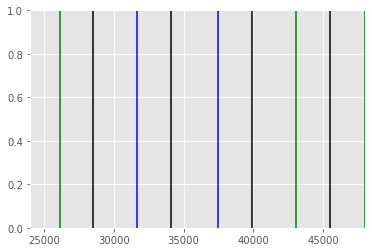

In [97]:
[plt.axvline(t, c='k') for t in trigs_rest]
[plt.axvline(t, c='r') for t in trigs_gest1]
[plt.axvline(t, c='b') for t in trigs_gest2]
[plt.axvline(t, c='g') for t in trigs_gest3]
plt.xlim(20*sfreq, 40*sfreq)

In [113]:
events = []

for i, t in enumerate([trigs_rest, trigs_gest1, trigs_gest2, trigs_gest3]):
    events.append(np.array([t, np.zeros(len(t)), i*np.ones(len(t))]).T)

events = np.vstack(events)

### Linear decoder - finger position (heavy...)

In [88]:
import spyeeg

In [4]:
raw = load_data()
raw.filter(1,300, picks=['ecog', 'misc'])
raw.set_eeg_reference('average')
raw.resample(600)
eeg = raw.get_data()[:-6].T
info = raw.info
fingers = raw.get_data()[-5:].T

Creating RawArray with float64 data, n_channels=66, n_times=507025
    Range : 0 ... 507024 =      0.000 ...   422.520 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 300.00 Hz
- Upper transition bandwidth: 75.00 Hz (-6 dB cutoff frequency: 337.50 Hz)
- Filter length: 3961 samples (3.301 sec)

ECoG channel type selected for re-referencing
Applying average reference.
Applying a custom ECoG reference.
90 events found
Event IDs: [1 2 3]
90 events found
Event IDs: [1 2 3]


In [6]:
decoder = spyeeg.models.TRF.TRFEstimator(tmin=0, tmax=.5, srate = info['sfreq'], alpha=10.**np.arange(-10, 11, 1), mtype='backward')

In [7]:
scores = decoder.xval_eval(stats.zscore(eeg, axis=0), stats.zscore(fingers, axis=0), fit_mode='from_cov_10')

Training/Evaluating fold 1/5


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/mak616/anaconda2/envs/spyeeg/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-7aac23483546>", line 1, in <module>
    scores = decoder.xval_eval(stats.zscore(eeg, axis=0), stats.zscore(fingers, axis=0), fit_mode='from_cov_10')
  File "/home/mak616/Desktop/sPyEEG/spyeeg/models/TRF.py", line 494, in xval_eval
    scores[kfold, :] = self.score(X[test, :], y[test, :])
  File "/home/mak616/Desktop/sPyEEG/spyeeg/models/TRF.py", line 396, in score
    yhat = self.predict(Xtest)
  File "/home/mak616/Desktop/sPyEEG/spyeeg/models/TRF.py", line 371, in predict
    X = lag_matrix(X, lag_samples=self.lags, filling=0.)
  File "/home/mak616/Desktop/sPyEEG/spyeeg/utils.py", line 119, in lag_matrix
    dframe.fillna(filling, inplace=True)
  File "/home/mak616/anaconda2/envs/spyeeg/lib/python3.8/site-packages/pandas/core/frame.py", line 4459

TypeError: object of type 'NoneType' has no len()

### Results summary

In [ ]:
plt.style.use('ggplot')

f, ax = plt.subplots(figsize=(12,5))

methods = ['Raw data (gamma) + LR', 'Wavelet (gamma) + SVM', 'Riemann', 'CSP (gamma) + LR', 'CSP (broad) + LR', 'CSP (gamma) + PCA + LDA', 'CSP (gamma) + PCA + TVLDA']
score_mean = [40.1, 56.6, 58.9, 86.6, 96.7, 91.7, 99.0]
score_std = [2., .7, .5, .7, .6, 1.7, .3]

for i, (label, mean, std) in enumerate(zip(methods, score_mean, score_std)):
    plt.bar(i, mean, yerr=std, label=label, width=.5)

plt.xticks(np.arange(len(methods)), methods, rotation=45, fontsize=12)
plt.ylabel('Accuracy (%) +/- 1 SD', fontsize=16)
plt.yticks(np.arange(0,110,10), fontsize=16)

plt.axhline(33, ls='--', c='k', alpha=.33)
plt.axvline(4.5, lw=3, c='k')
plt.ylim(0,100)
plt.text(2, 105, 'Ours', va='center', ha='center', fontsize=20, weight='bold')
plt.text(5.5, 105, 'SOTA', va='center', ha='center', fontsize=20, weight='bold')
plt.title('Gesture classification\n\n', fontsize=20)
# plt.tight_layout()

plt.savefig('./Classifier.png', bbox_inches='tight')

In [80]:
std

2.0